registration with template

In [ ]:
import os

os.environ['PATH'] += ':/opt/ANTs/bin' # ensure the ANTs binaries are in $PATH
os.environ['ANTSPATH'] = '/opt/ANTs/bin/'

In [ ]:
import os
import glob
import numpy as np
import pandas as pd

TYPE = 'female' # male, female, combined

images_dir = f'/mnt/sda1/Repos/a-eye/Output/eye_model/{TYPE}/input/cropped_images/'
output_dir = f'/mnt/sda1/Repos/a-eye/Output/eye_model/{TYPE}/output/registrationToTemplate/'
template = f'/mnt/sda1/Repos/a-eye/Output/eye_model/{TYPE}/output/templateConstruction/template0.nii.gz'

for file in sorted(glob.glob(images_dir + '*_cropped.nii.gz')):
        filename = os.path.basename(file)
        output_folder = output_dir + filename.split("_")[0] + '/'
        # print(output_folder)

        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        ## antsRegistrationSyNQuick # s: rigid + affine + deformable syn (3 stages)
        command1 = 'antsRegistrationSyNQuick.sh -d 3' + \
        ' -m ' + file                                 + \
        ' -f ' + template                             + \
        ' -t ' + 's'                                  + \
        ' -o ' + output_folder                        + \
        ' -n ' + '16'
        # print(command1)
        os.system(command1)


get sex from metadata and create lists

In [ ]:
import pandas as pd

metadata = "/mnt/sda1/Repos/a-eye/Output/metadata/sub_metadata.csv"
metadata_df = pd.read_csv(metadata)

males = metadata_df[metadata_df['Sex'] == 'M']
male_list = males['Subject'].tolist() # 594

females = metadata_df[metadata_df['Sex'] == 'F']
female_list = females['Subject'].tolist() # 616

copy atlas' labels to input folder
---

combined

In [ ]:
import shutil

source_dir = "/mnt/sda1/Repos/a-eye/Data/SHIP_dataset/non_labeled_dataset/non_labeled_dataset_nifti_reg_2/"
dest_dir = "/home/jaimebarranco/Desktop/eye_model/combined/input/cropped_labels/atlas/"

for file in sorted(glob.glob(source_dir + '*/labels.nii.gz', recursive=True)):
    filename = os.path.basename(file)
    # print(file.split("/")[-2])
    shutil.copy(file, os.path.join(dest_dir, f'{file.split("/")[-2]}.nii.gz'))

per sex

In [ ]:
import shutil
from pathlib import Path

source_dir = "/mnt/sda1/Repos/a-eye/Data/SHIP_dataset/non_labeled_dataset/non_labeled_dataset_nifti_reg_2"
dest_dir = "/mnt/sda1/Repos/a-eye/Output/eye_model/female/input/cropped_labels/atlas"

# Create the destination directory if it doesn't exist
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# for file in sorted(glob.glob(input_atlas_labels_dir + '*/labels.nii.gz', recursive=True)):
for file in female_list:
    # Generate the source file path based on the subject ID
    source_file = Path(f'{source_dir}/{file}/labels.nii.gz')

    # Check if the source file exists
    if os.path.exists(source_file):        
        # Copy the source file to the destination folder
        shutil.copy(source_file, f'{dest_dir}/{file}.nii.gz')

copy nnunet labels to input folder
---

combined

In [ ]:
import shutil
import glob

dest_dir = "/mnt/sda1/Repos/a-eye/a-eye_segmentation/deep_learning/nnUNet/nnUNet/nnUNet_inference/no_postprocessing_cropped_alligned/"
source_dir = "/home/jaimebarranco/Desktop/eye_model/combined/input/cropped_labels/nnunet/"

for file in sorted(glob.glob(dest_dir + '*.nii.gz', recursive=True)):
    filename = os.path.basename(file)
    # print(filename.split("_")[0])
    shutil.copy(file, os.path.join(source_dir, f'{filename.split("_")[0]}.nii.gz'))

per sex

In [ ]:
import shutil
from pathlib import Path

source_dir = "/mnt/sda1/Repos/a-eye/a-eye_segmentation/deep_learning/nnUNet/nnUNet/nnUNet_inference/no_postprocessing_cropped_alligned"
dest_dir = "/mnt/sda1/Repos/a-eye/Output/eye_model/female/input/cropped_labels/nnunet"

# Create the destination directory if it doesn't exist
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# for file in sorted(glob.glob(input_atlas_labels_dir + '*/labels.nii.gz', recursive=True)):
for file in female_list:
    # Generate the source file path based on the subject ID
    source_file = Path(f'{source_dir}/{file}_cropped_alligned.nii.gz')

    # Check if the source file exists
    if os.path.exists(source_file):
        # Copy the source file to the destination folder
        shutil.copy(source_file, f'{dest_dir}/{file}.nii.gz')

apply transform to labels from subjects to template (direct transform)
---

In [ ]:
labels_dir = '/mnt/sda1/Repos/a-eye/Output/eye_model/male/input/cropped_labels/atlas/' # atlas or nnunet
output_dir = '/mnt/sda1/Repos/a-eye/Output/eye_model/male/output/registrationToTemplate/'
template = '/mnt/sda1/Repos/a-eye/Output/eye_model/male/output/templateConstruction/template0.nii.gz'

for file in sorted(glob.glob(labels_dir + '*.nii.gz')):
        filename = os.path.basename(file)
        output_folder = output_dir + filename.split(".")[0] + '/'
        # print(output_folder)
        
        # antsApplyTransforms with inverse transform to get the template labels into subject space
        command2 = 'antsApplyTransforms -d 3 ' + \
        ' -i ' +  file + \
        ' -r ' +  template + \
        ' -t ' + output_folder + '1Warp.nii.gz' + \
        ' -t ' + output_folder + '0GenericAffine.mat' + \
        ' -n ' + 'MultiLabel' + \
        ' -o ' +  output_folder + 'labels_atlas.nii.gz' + \
        ' --float 0 --verbose 1'
        # print(command2)
        os.system(command2)

        # Dealing with files in that folder
        # for f in glob.glob(output_image_path + 'labels.nii.gz'):
        #     os.remove(f)

probability per voxel to belong to a certain structure of the eye
---

array generation

In [1]:
import nibabel as nb
import numpy as np
import glob, os

TYPE = 'combined' # male, female, combined
METHOD = 'nnunet' # 'atlas' or 'nnunet'

labels_dir = f'/mnt/sda1/Repos/a-eye/Output/eye_model/{TYPE}/output/registrationToTemplate'
maps_dir = f'/mnt/sda1/Repos/a-eye/Output/eye_model/{TYPE}/output/maps/{METHOD}'
os.makedirs(maps_dir, exist_ok=True)
num_images = len(os.listdir(labels_dir))

# sample image to get the shape
sample_image_path = sorted(glob.glob(labels_dir + '/*/labels_nnunet.nii.gz'))[0] # atlas or nnunet
sample_image = nb.load(sample_image_path)
image_shape = sample_image.shape  # (77, 95, 94)
print(image_shape)

(77, 95, 94)


In [ ]:
# (1210, 77, 95, 94) array generation
labels_matrix = np.empty((num_images, *image_shape))  # (1210, 77, 95, 94)
for idx, file in enumerate(sorted(glob.glob(labels_dir + f'/*/labels_{METHOD}.nii.gz'))):  # atlas or nnunet
    sub = file.split("/")[-2] # str
    # print(idx)
    # print(file)
    # print(sub)
    labels = nb.load(file)
    # labels_shape = labels.shape
    # print(labels_shape)
    labels_data = labels.get_fdata()
    labels_matrix[idx] = labels_data

voxel_arrays = np.moveaxis(labels_matrix, 0, -1)
print(voxel_arrays.shape)  # (77, 95, 94, 1210)

In [ ]:
# Save voxel_arrays to a .npy file
np.save(f'{maps_dir}/voxel_arrays.npy', voxel_arrays)

In [2]:
# Load voxel_arrays
voxel_arrays = np.load(f'{maps_dir}/voxel_arrays.npy')

max prob map

In [3]:
from collections import Counter

# matrices for most likely tissue and probability of that tissue (divided by number of images)
stat_matrix = np.empty(image_shape) # statistic matrix
prob_matrix = np.empty(image_shape)

# mode extended and probability calculation for each voxel
for x in range(image_shape[0]):
    for y in range(image_shape[1]):
        for z in range(image_shape[2]):
            voxel_values = voxel_arrays[x, y, z, :]
            freq = Counter(voxel_values)
            voxel_frequencies = freq.most_common() # [(label, frequency), ...]
            # [0][0] most frequent value, [1][0] second most frequent value
            # [0][1] most frequent frequency, [1][1] second most frequent frequency
            voxel_value = voxel_frequencies[0][0]
            voxel_value_frequency = voxel_frequencies[0][1]
            stat_matrix[x, y, z] = voxel_value

In [4]:
# Save the entire max prob map to a .npy file
np.save(f'{maps_dir}/max_prob_map.npy', stat_matrix)


In [ ]:

# Save max prob map as nifti
stat_nifti = nb.Nifti1Image(stat_matrix, sample_image.affine, sample_image.header)
nb.save(stat_nifti, f'{maps_dir}/max_prob_map.nii.gz')

probs

In [ ]:
# Probability of each structure per voxel
num_labels = 10
probs = np.zeros((image_shape[0], image_shape[1], image_shape[2], num_labels))
for label in range(num_labels):
    probs[:, :, :, label] = np.count_nonzero(voxel_arrays == label, axis=3) / num_images

In [ ]:
probs[34, 66, 66, :] # example of probabilities for a voxel

In [ ]:
# Save the prob matrix to a .npy file
np.save(f'{maps_dir}/probs.npy', probs)

In [ ]:
# save the probs as a nifti file
probs_nifti = nb.Nifti1Image(probs[..., 9], sample_image.affine, sample_image.header)
nb.save(probs_nifti, f'{maps_dir}/probs_sup_mus.nii.gz')

In [ ]:
"""Load probs matrix"""
import numpy as np
probs = np.load(f'{maps_dir}/probs.npy')

colors

In [ ]:
# Define names for the different labels (tissues)
label_names = {
    0: 'background',
    1: 'lens',
    2: 'globe',
    3: 'optic nerve',
    4: 'intraconal fat',
    5: 'extraconal fat',
    6: 'lateral rectus muscle',
    7: 'medial rectus muscle',
    8: 'inferior rectus muscle',
    9: 'superior rectus muscle',
}

# define colors for the different labels (tissues)
colors = {
    0: [0, 0, 0], # background - black
    1: [1, 0, 0],  # lens - tab:red
    2: [0, 1, 0],  # globe - green
    3: [0, 0, 1],  # optic nerve - tab:blue
    4: [1, 1, 0],  # intraconal fat - yellow
    5: [0, 1, 1],  # extraconal fat - cyan
    6: [1, 0, 1],  # lateral rectus muscle - magenta
    7: [0, 1, 0.5],  # medial rectus muscle - aquamarine
    8: [1, 0.5, 0],  # inferior rectus muscle - purple
    9: [0.5, 0, 1],  # superior rectus muscle - orange
}

distribution of probs per label

In [ ]:
''' Distribution of probabilities per label '''

import os
import numpy as np
import matplotlib.pyplot as plt

TYPE = 'combined' # male, female, combined
METHOD = 'atlas' # 'atlas' or 'nnunet'

labels_dir = f'/mnt/sda1/Repos/a-eye/Output/eye_model/{TYPE}/output/registrationToTemplate'
maps_dir = f'/mnt/sda1/Repos/a-eye/Output/eye_model/{TYPE}/output/maps/{METHOD}'

# Load probs matrix
probs = np.load(f'{maps_dir}/probs.npy')

# Number of bins for the histogram
num_bins = 10

# Prepare the bins, starting slightly above 0 to avoid zero probabilities
bins = np.linspace(1e-6, 1, num_bins + 1)

# Plot histogram for each label, excluding label 0
for label in range(len(colors)):
    # Initialize a new plot for each label
    fig, ax = plt.subplots(figsize=(10, 6))

    # Extract probabilities for the current label
    probabilities = probs[..., label].flatten()

    # Filter probabilities greater than 0.1
    probabilities = probabilities[probabilities > 0.1]
    
    # Compute histogram
    counts, bin_edges = np.histogram(probabilities, bins=bins)
    
    # Plot the histogram as bars
    ax.bar(bin_edges[:-1], counts, width=(bin_edges[1] - bin_edges[0]), 
        align='edge', label=f'{label_names[label]}', color=colors[label], alpha=0.7)
    
    # Customize the plot
    ax.set_xlabel('Probability')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of Probabilities for Label {label_names[label]}')
    ax.legend()
    ax.grid(True)
    ax.set_xlim(left=0.1)  # Set the x-axis to start at 0.1
    
    # Save the plot as a PNG file
    os.makedirs(f'{maps_dir}/histogram_per_label/adjusted', exist_ok=True)
    fig.savefig(f'{maps_dir}/histogram_per_label/adjusted/{label}_{label_names[label]}_adjusted.png', format='png')
    
    # Show the plot
    plt.show

HSV - my way

In [5]:
""" Create ponderated RGB image for all subjects per label"""

import numpy as np
import nibabel as nb
import glob, os
import matplotlib.colors as mcolors
# matplotlib (https://matplotlib.org/stable/gallery/color/named_colors.html#sphx-glr-gallery-color-named-colors-py)

TYPE = 'combined' # male, female, combined
METHOD = 'nnunet' # 'atlas' or 'nnunet'

labels_dir = f'/mnt/sda1/Repos/a-eye/Output/eye_model/{TYPE}/output/registrationToTemplate'
maps_dir = f'/mnt/sda1/Repos/a-eye/Output/eye_model/{TYPE}/output/maps/{METHOD}'

# sample image to get the shape
sample_image_path = sorted(glob.glob(labels_dir + f'/*/labels_{METHOD}.nii.gz'))[0]
sample_image = nb.load(sample_image_path)
image_shape = sample_image.shape
print(image_shape)

# define colors for the different labels (tissues)
colors = {
    0: [0, 0, 0],  # background - black
    1: [255, 0, 0],  # lens - tab:red
    2: [0, 255, 0],  # globe - green
    3: [0, 0, 255],  # optic nerve - tab:blue
    4: [255, 255, 0],  # intraconal fat - yellow
    5: [0, 255, 255],  # extraconal fat - cyan
    6: [255, 0, 255],  # lateral rectus muscle - magenta
    7: [144, 92, 44],  # medial rectus muscle - brown
    8: [255, 140, 0],  # inferior rectus muscle - orange
    9: [128, 0, 128],  # superior rectus muscle - purple
}

# Define names for the different labels (tissues)
label_names = {
    0: '0_background',
    1: '1_lens',
    2: '2_globe',
    3: '3_optic_nerve',
    4: '4_intraconal_fat',
    5: '5_extraconal_fat',
    6: '6_lateral_rectus_muscle',
    7: '7_medial_rectus_muscle',
    8: '8_inferior_rectus_muscle',
    9: '9_superior_rectus_muscle',
}

# Load probability matrix
# matrix = np.load('/mnt/sda1/Repos/a-eye/Output/eye_model/combined/output/maps/nnunet/voxel_arrays.npy')
# matrix_shape = matrix.shape
num_subjects = 1210  # matrix_shape[3]
probs = np.load(f'{maps_dir}/probs.npy')

# colors to rgb using matplotlib
rgb_colors = {}
for key, value in colors.items():
    value = [x / 255 for x in value]  # normalize to [0, 1]
    rgb_colors[key] = mcolors.to_rgb(value) # no alpha channel
print("rgb: ", rgb_colors)

# colors to hsv
hsv_colors = {}
for key, value in rgb_colors.items():
    hsv_colors[key] = mcolors.rgb_to_hsv(value)
print("hsv: ", hsv_colors)

# Create the output image
output_image_rgb = np.zeros((image_shape[0], image_shape[1], image_shape[2], 3)) # 3 channels

# Reduce intensity based on probabilities
for i in range(image_shape[0]):
    for j in range(image_shape[1]):
        for k in range(image_shape[2]):
            blended_rgb = np.zeros(3)
            for label in range(len(colors)):
                hsv = hsv_colors[label].copy()
                hsv[1] *= probs[i, j, k, label]  # Reduce intensity (Saturation)
                hsv[2] *= probs[i, j, k, label]  # Reduce intensity (Value)
                blended_rgb += mcolors.hsv_to_rgb(hsv)
            output_image_rgb[i, j, k] = blended_rgb

# Normalize to keep RGB values within [0, 1]
output_image_rgb = np.clip(output_image_rgb, 0, 1)

# Convert back to 0-255 range for visualization
output_image_rgb = (output_image_rgb * 255).astype(np.uint8)

# save the output_rgb_image as a .npy file
np.save(f'{maps_dir}/prob_map.npy', output_image_rgb)

# save the output_rgb_image as a nifti file
output_image_nifti = nb.Nifti1Image(output_image_rgb, sample_image.affine, sample_image.header)
nb.save(output_image_nifti, f'{maps_dir}/prob_map.nii.gz')

(77, 95, 94)
rgb:  {0: (0.0, 0.0, 0.0), 1: (1.0, 0.0, 0.0), 2: (0.0, 1.0, 0.0), 3: (0.0, 0.0, 1.0), 4: (1.0, 1.0, 0.0), 5: (0.0, 1.0, 1.0), 6: (1.0, 0.0, 1.0), 7: (0.5647058823529412, 0.3607843137254902, 0.17254901960784313), 8: (1.0, 0.5490196078431373, 0.0), 9: (0.5019607843137255, 0.0, 0.5019607843137255)}
hsv:  {0: array([0., 0., 0.]), 1: array([0., 1., 1.]), 2: array([0.33333333, 1.        , 1.        ]), 3: array([0.66666667, 1.        , 1.        ]), 4: array([0.16666667, 1.        , 1.        ]), 5: array([0.5, 1. , 1. ]), 6: array([0.83333333, 1.        , 1.        ]), 7: array([0.08      , 0.69444444, 0.56470588]), 8: array([0.09150327, 1.        , 1.        ]), 9: array([0.83333333, 1.        , 0.50196078])}


HSV - Yasser's way

In [ ]:
import numpy as np
import nibabel as nb
import glob, os
import matplotlib.colors as mcolors

TYPE = 'combined' # male, female, combined
METHOD = 'atlas' # 'atlas' or 'nnunet'

labels_dir = f'/mnt/sda1/Repos/a-eye/Output/eye_model/{TYPE}/output/registrationToTemplate'
maps_dir = f'/mnt/sda1/Repos/a-eye/Output/eye_model/{TYPE}/output/maps/{METHOD}'

# sample image to get the shape
sample_image_path = sorted(glob.glob(labels_dir + f'/*/labels_{METHOD}.nii.gz'))[0]  # atlas or nnunet
sample_image = nb.load(sample_image_path)
image_shape = sample_image.shape  # (77, 95, 94)
print(image_shape)

# define colors for the different labels (tissues)
colors = {
    0: [0, 0, 0], # background - black
    1: [1, 0, 0],  # lens - tab:red
    2: [0, 1, 0],  # globe - green
    3: [0, 0, 1],  # optic nerve - tab:blue
    4: [1, 1, 0],  # intraconal fat - yellow
    5: [0, 1, 1],  # extraconal fat - cyan
    6: [1, 0, 1],  # lateral rectus muscle - magenta
    7: [0, 1, 0.5],  # medial rectus muscle - aquamarine
    8: [1, 0.5, 0],  # inferior rectus muscle - purple
    9: [0.5, 0, 1],  # superior rectus muscle - orange
}

# Define names for the different labels (tissues)
label_names = {
    0: '0_background',
    1: '1_lens',
    2: '2_globe',
    3: '3_optic_nerve',
    4: '4_intraconal_fat',
    5: '5_extraconal_fat',
    6: '6_lateral_rectus_muscle',
    7: '7_medial_rectus_muscle',
    8: '8_inferior_rectus_muscle',
    9: '9_superior_rectus_muscle',
}

# Load probabilities
probs = np.load(f'{maps_dir}/probs.npy')

# colors to rgb using matplotlib
rgb_colors = {}
for key, value in colors.items():
    rgb_colors[key] = mcolors.to_rgb(value)  # no alpha channel
print("rgb: ", rgb_colors)

# colors to hsv
hsv_colors = {}
for key, value in rgb_colors.items():
    hsv_colors[key] = mcolors.rgb_to_hsv(value)
print("hsv: ", hsv_colors)

# Initialize the volumes for each channel at the same dimension as the initial volume
dim = np.array([image_shape[0], image_shape[1], image_shape[2]])
H = np.zeros(dim)
S = np.zeros(dim)
V = np.zeros(dim)
Isum = np.zeros(dim)
Im = np.zeros(dim)

# Accumulate HSV values
for label_num in range(1, len(colors)):
    label_name = label_names[label_num]
    It = probs[..., label_num]

    H += It * hsv_colors[label_num][0]  # H
    S += It * hsv_colors[label_num][1]  # S
    V += It * hsv_colors[label_num][2]  # V

    Isum += It
    Im = np.maximum(Im, It)

# Find indices where Isum is not zero
ind = np.where(Isum != 0)

# Normalize HSV values
# H[ind] /= Isum[ind]
S[ind] /= Isum[ind]
V[ind] /= Isum[ind]

# Scale by the maximum intensity
# H *= Im
S *= Im
V *= Im

# Create the output image in HSV format
output_image_hsv = np.stack([H, S, V], axis=3)

# Convert HSV to RGB
output_image_rgb = np.zeros((image_shape[0], image_shape[1], image_shape[2], 3))
for i in range(image_shape[0]):
    for j in range(image_shape[1]):
        for k in range(image_shape[2]):
            output_image_rgb[i, j, k] = mcolors.hsv_to_rgb(output_image_hsv[i, j, k])

# Normalize to keep RGB values within [0, 1]
output_image_rgb = np.clip(output_image_rgb, 0, 1)

# Convert back to 0-255 range for visualization
output_image_rgb = (output_image_rgb * 255).astype(np.uint8)

# Save the output_rgb_image as a .npy file
np.save(f'{maps_dir}/prob_map_hsv_v2.npy', output_image_rgb)

# Save the output_rgb_image as a nifti file
output_image_nifti = nb.Nifti1Image(output_image_rgb, sample_image.affine, sample_image.header)
nb.save(output_image_nifti, f'{maps_dir}/prob_map_hsv_v2.nii.gz')


RGB - Yasser

In [ ]:
""" Create ponderated RGB image for all subjects per label"""

import numpy as np
import nibabel as nb
import glob, os

TYPE = 'combined' # male, female, combined
METHOD = 'atlas' # 'atlas' or 'nnunet'

labels_dir = f'/mnt/sda1/Repos/a-eye/Output/eye_model/{TYPE}/output/registrationToTemplate'
maps_dir = f'/mnt/sda1/Repos/a-eye/Output/eye_model/{TYPE}/output/maps/{METHOD}'

# sample image to get the shape
sample_image_path = sorted(glob.glob(labels_dir + f'/*/labels_{METHOD}.nii.gz'))[0] # atlas or nnunet
sample_image = nb.load(sample_image_path)
image_shape = sample_image.shape  # (77, 95, 94)
print(image_shape)

# define colors for the different labels (tissues)
colors = {
    0: [0, 0, 0], # background - black
    1: [1, 0, 0],  # lens - tab:red
    2: [0, 1, 0],  # globe - green
    3: [0, 0, 1],  # optic nerve - tab:blue
    4: [1, 1, 0],  # intraconal fat - yellow
    5: [0, 1, 1],  # extraconal fat - cyan
    6: [1, 0, 1],  # lateral rectus muscle - magenta
    7: [0, 1, 0.5],  # medial rectus muscle - aquamarine
    8: [1, 0.5, 0],  # inferior rectus muscle - purple
    9: [0.5, 0, 1],  # superior rectus muscle - orange
}

# Define names for the different labels (tissues)
label_names = {
    0: '0_background',
    1: '1_lens',
    2: '2_globe',
    3: '3_optic_nerve',
    4: '4_intraconal_fat',
    5: '5_extraconal_fat',
    6: '6_lateral_rectus_muscle',
    7: '7_medial_rectus_muscle',
    8: '8_inferior_rectus_muscle',
    9: '9_superior_rectus_muscle',
}

# Load voxel_arrays
probs = np.load(f'{maps_dir}/probs.npy')

# Initialize the volumes for each channel at the same dimension as the initial volume
dim = np.array([image_shape[0], image_shape[1], image_shape[2]])
Ir = np.zeros(dim)
Ig = np.zeros(dim)
Ib = np.zeros(dim)
Isum = np.zeros(dim)
Im = np.zeros(dim)

# Iterate over the labels
for label_num in range(1, len(colors)):
    # label_num = 1
    label_name = label_names[label_num]
    It = probs[..., label_num]

    # Accumulates the weighted volume into the Ir array, scaled by
    # the color component for the current track
    Ir += It * colors[label_num][0]  # R
    Ig += It * colors[label_num][1]  # G
    Ib += It * colors[label_num][2]  # B

    # Accumulates the unweighted volume into the Isum array
    Isum += It

    # Takes the element-wise maximum between the current Im and It
    Im = np.maximum(Im, It)

# Find indices where Isum is not zero
ind = np.where(Isum != 0)

# Normalize RGB values
Ir[ind] /= Isum[ind]
Ig[ind] /= Isum[ind]
Ib[ind] /= Isum[ind]

# Scale by the maximum intensity
Ir *= Im
Ig *= Im
Ib *= Im

# Create the RGB image with dimensions (77, 95, 94, 3)
output_image_rgb = np.stack([Ir, Ig, Ib], axis=3)

# save the output_rgb_image as a nifti file
output_image_nifti = nb.Nifti1Image(output_image_rgb, sample_image.affine, sample_image.header)
nb.save(output_image_nifti, f'{maps_dir}/prob_map_rgb.nii.gz')

load rgb image

In [6]:
"""Load rgb_image"""
import nibabel as nb

TYPE = 'combined' # male, female, combined
METHOD = 'nnunet' # 'atlas' or 'nnunet'

maps_dir = f'/mnt/sda1/Repos/a-eye/Output/eye_model/{TYPE}/output/maps/{METHOD}'

output_image_rgb_nii = nb.load(f'{maps_dir}/prob_map.nii.gz')
output_image_rgb = output_image_rgb_nii.get_fdata()

In [8]:
import numpy as np

TYPE = 'combined' # male, female, combined
METHOD = 'nnunet' # 'atlas' or 'nnunet'

maps_dir = f'/mnt/sda1/Repos/a-eye/Output/eye_model/{TYPE}/output/maps/{METHOD}'

output_image_rgb = np.load(f'{maps_dir}/prob_map_hsv.npy')

save slices as png files

In [9]:
''' Save all slices as PNG files '''

import os
import matplotlib.pyplot as plt

output_dir = f'{maps_dir}/prob_map_{METHOD}'  # Directory to save the PNG files
os.makedirs(output_dir, exist_ok=True)

for z in range(output_image_rgb.shape[2]):
    slice_rgb = output_image_rgb[:, :, z, :]
    plt.imshow(slice_rgb)
    plt.axis('off')
    plt.savefig(f"{output_dir}/slice_{z}.png", bbox_inches='tight', pad_inches=0)
    plt.close()

visualizer z=67

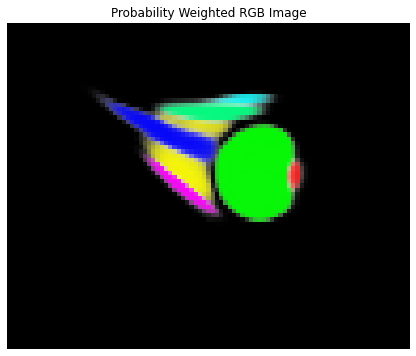

In [10]:
''' Visualize'''

import matplotlib.pyplot as plt

# To visualize a single slice (e.g., the first slice in the third dimension)
plt.figure(figsize=(8, 6))  # replace width and height with desired values
plt.imshow(output_image_rgb[..., 67, :], interpolation='nearest')
plt.title('Probability Weighted RGB Image')
plt.axis('off')
plt.show()

visualizer with Z-axis slider

In [ ]:
''' Visualize with a Z-axis slider'''

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# Function to rotate an image 90 degrees to the left
def rotate_image(image):
    return np.rot90(image, k=1)

# Function to create a 2D plot for a specific z slice
def plot_2d_slice(rgb_image, z_index):
    plt.figure(figsize=(8, 12))
    plt.imshow(rgb_image[:, :, z_index], interpolation='none')
    plt.title(f'Slice at z = {z_index}')
    plt.axis('off')
    plt.show()

# Interactive function to update the plot based on slider value
def update_plot(z_index):
    plot_2d_slice(rotated_output_image_rgb, z_index)

# Rotate prob_map
rotated_output_image_rgb = rotate_image(output_image_rgb)

# Create the slider widget
z_slider = widgets.IntSlider(min=0, max=rotated_output_image_rgb.shape[2]-1, step=1, value=0, description='Z-axis')

# Use interact to update the plot when the slider value changes
interact(update_plot, z_index=z_slider)

axial - visualizer with overlap with the template image

In [21]:
''' Visualize with an interactive 3D plot''' 
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

TYPE = 'combined' # male, female, combined
METHOD = 'nnunet' # 'atlas' or 'nnunet'

# Load the template image
template_path = f'/mnt/sda1/Repos/a-eye/Output/eye_model/{TYPE}/output/templateConstruction/template0.nii.gz'
template_img = nb.load(template_path)
template_data = template_img.get_fdata()

# Load the output image (assuming output_image_rgb is loaded similarly)
maps_dir = f'/mnt/sda1/Repos/a-eye/Output/eye_model/{TYPE}/output/maps/{METHOD}'
output_image_rgb = np.load(f'{maps_dir}/prob_map.npy')

# Output dir
output_dir = f'/mnt/sda1/Repos/a-eye/Output/eye_model/{TYPE}/output/captures/{METHOD}'
os.makedirs(output_dir, exist_ok=True)

# Function to rotate an image 90 degrees to the left
def rotate_image(image):
    return np.rot90(image, k=1)

# Function to flip an image left to right
def flip_image(image):
    return np.fliplr(image)

# Create a function to plot both images overlapped
def plot_images(opacity, overlay, z_index):
    fig, ax = plt.subplots(figsize=(8, 8))

    # rotate and flip
    rotated_template = rotate_image(template_data)
    flipped_template = flip_image(rotated_template)
    rotated_prob_map = rotate_image(output_image_rgb)
    flipped_prob_map = flip_image(rotated_prob_map)

    # Plot the flipped template image
    ax.imshow(flipped_template[:, :, z_index], cmap='gist_gray', interpolation='none', alpha=1)

    # Extract RGB channels from prob_map
    rgb_channels = flipped_prob_map[..., z_index, :]

    # Normalize RGB channels for intensity adjustment
    rgb_channels_norm = rgb_channels / np.max(rgb_channels)

    # Apply intensity adjustment to prob_map
    adjusted_prob_map = rgb_channels_norm * opacity

    # Overlay the prob_map with adjustable transparency
    ax.imshow(adjusted_prob_map, alpha=overlay)

    # Set title and turn off axis
    # ax.set_title('Overlayed Image')
    ax.axis('off')

    # Save the plot as a PNG file
    plt.savefig(f'{output_dir}/atlas_axial_prob_map.png', bbox_inches='tight')

    # Show the plot
    plt.show()

# Create sliders for adjusting alpha of probability map and overlay, and z-axis slice
opacity_slider = widgets.FloatSlider(min=0, max=1, step=0.05, value=1, description='Opacity')
overlay_slider = widgets.FloatSlider(min=0, max=1, step=0.05, value=0.5, description='Overlay')
z_slider = widgets.IntSlider(min=0, max=template_data.shape[2] - 1, step=1, value=67, description='Z-axis')

# Create an interactive plot
interact(plot_images, opacity=opacity_slider, overlay=overlay_slider, z_index=z_slider)


interactive(children=(FloatSlider(value=1.0, description='Opacity', max=1.0, step=0.05), FloatSlider(value=0.5…

<function __main__.plot_images(opacity, overlay, z_index)>

sagittal - visualizer with overlap with the template image

In [23]:
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

TYPE = 'combined'  # male, female, combined
METHOD = 'nnunet'  # 'atlas' or 'nnunet'

# Load the template image
template_path = f'/mnt/sda1/Repos/a-eye/Output/eye_model/{TYPE}/output/templateConstruction/template0.nii.gz'
template_img = nb.load(template_path)
template_data = template_img.get_fdata()

# Load the output image (assuming output_image_rgb is loaded similarly)
maps_dir = f'/mnt/sda1/Repos/a-eye/Output/eye_model/{TYPE}/output/maps/{METHOD}'
output_image_rgb = np.load(f'{maps_dir}/prob_map_hsv.npy')

# Output dir
output_dir = f'/mnt/sda1/Repos/a-eye/Output/eye_model/{TYPE}/output/captures/{METHOD}'
os.makedirs(output_dir, exist_ok=True)

# Function to flip an image left to right
def flip_image(image):
    return np.fliplr(image)

# Function to rotate an image 90 degrees to the left
def rotate_image(image):
    return np.rot90(image, k=1, axes=(1, 2))

# Function to plot images along the x-axis
def plot_images_x(opacity, overlay, x_index):
    fig, ax = plt.subplots(figsize=(8, 8))

    # Rotate and flip
    flipped_template = flip_image(template_data)
    rotated_template = rotate_image(flipped_template)
    flipped_prob_map = flip_image(output_image_rgb)
    rotated_prob_map = rotate_image(flipped_prob_map)

    # Plot the flipped template image
    ax.imshow(rotated_template[x_index, :, :], cmap='gist_gray', interpolation='none', alpha=1)

    # Extract RGB channels from prob_map
    rgb_channels = rotated_prob_map[x_index, :, :, :]

    # Normalize RGB channels for intensity adjustment
    rgb_channels_norm = rgb_channels / np.max(rgb_channels)

    # Apply intensity adjustment to prob_map
    adjusted_prob_map = rgb_channels_norm * opacity

    # Overlay the prob_map with adjustable transparency
    ax.imshow(adjusted_prob_map, alpha=overlay)

    # Set title and turn off axis
    ax.axis('off')

    # Save the plot as a PNG file
    plt.savefig(f'{output_dir}/atlas_sagittal_prob_map.png', bbox_inches='tight')

    plt.show()

# Create sliders for adjusting alpha of probability map and overlay, and x-axis slice
opacity_slider = widgets.FloatSlider(min=0, max=1, step=0.05, value=1, description='Opacity')
overlay_slider = widgets.FloatSlider(min=0, max=1, step=0.05, value=0.5, description='Overlay')
x_slider = widgets.IntSlider(min=0, max=template_data.shape[0] - 1, step=1, value=28, description='X-axis')

# Create an interactive plot for the x-axis
interact(plot_images_x, opacity=opacity_slider, overlay=overlay_slider, x_index=x_slider)


interactive(children=(FloatSlider(value=1.0, description='Opacity', max=1.0, step=0.05), FloatSlider(value=0.5…

<function __main__.plot_images_x(opacity, overlay, x_index)>

coronal - visualizer with overlap with the template image

In [24]:
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

TYPE = 'combined'  # male, female, combined
METHOD = 'nnunet'  # 'atlas' or 'nnunet'

# Load the template image
template_path = f'/mnt/sda1/Repos/a-eye/Output/eye_model/{TYPE}/output/templateConstruction/template0.nii.gz'
template_img = nb.load(template_path)
template_data = template_img.get_fdata()

# Load the output image (assuming output_image_rgb is loaded similarly)
maps_dir = f'/mnt/sda1/Repos/a-eye/Output/eye_model/{TYPE}/output/maps/{METHOD}'
output_image_rgb = np.load(f'{maps_dir}/prob_map_hsv.npy')

# Output dir
output_dir = f'/mnt/sda1/Repos/a-eye/Output/eye_model/{TYPE}/output/captures/{METHOD}'
os.makedirs(output_dir, exist_ok=True)

# Function to flip an image left to right
def flip_image(image):
    return np.flipud(image)

# Function to rotate an image 90 degrees to the left
def rotate_image(image):
    return np.rot90(image, k=1, axes=(0, 2))

# Function to plot images along the y-axis
def plot_images_y(opacity, overlay, y_index):
    fig, ax = plt.subplots(figsize=(8, 8))

    # Rotate and flip
    flipped_template = flip_image(template_data)
    rotated_template = rotate_image(flipped_template)
    flipped_prob_map = flip_image(output_image_rgb)
    rotated_prob_map = rotate_image(flipped_prob_map)

    # Plot the flipped template image
    ax.imshow(rotated_template[:, y_index, :], cmap='gist_gray', interpolation='none', alpha=1)

    # Extract RGB channels from prob_map
    rgb_channels = rotated_prob_map[:, y_index, :, :]

    # Normalize RGB channels for intensity adjustment
    rgb_channels_norm = rgb_channels / np.max(rgb_channels)

    # Apply intensity adjustment to prob_map
    adjusted_prob_map = rgb_channels_norm * opacity

    # Overlay the prob_map with adjustable transparency
    ax.imshow(adjusted_prob_map, alpha=overlay)

    # Set title and turn off axis
    ax.axis('off')

    # Save the plot as a PNG file
    plt.savefig(f'{output_dir}/atlas_coronal_prob_map.png', bbox_inches='tight')

    plt.show()

# Create sliders for adjusting alpha of probability map and overlay, and y-axis slice
opacity_slider = widgets.FloatSlider(min=0, max=1, step=0.05, value=1, description='Opacity')
overlay_slider = widgets.FloatSlider(min=0, max=1, step=0.05, value=0.5, description='Overlay')
y_slider = widgets.IntSlider(min=0, max=template_data.shape[1] - 1, step=1, value=39, description='Y-axis')

# Create an interactive plot for the y-axis
interact(plot_images_y, opacity=opacity_slider, overlay=overlay_slider, y_index=y_slider)


interactive(children=(FloatSlider(value=1.0, description='Opacity', max=1.0, step=0.05), FloatSlider(value=0.5…

<function __main__.plot_images_y(opacity, overlay, y_index)>

Volumes
---

In [12]:
import nibabel as nb
import numpy as np

TYPE = 'combined' # male, female, combined
METHOD = 'nnunet' # 'atlas' or 'nnunet'

labels_dir = f'/mnt/sda1/Repos/a-eye/Output/eye_model/{TYPE}/output/registrationToTemplate'
maps_dir = f'/mnt/sda1/Repos/a-eye/Output/eye_model/{TYPE}/output/maps/{METHOD}'

# load max prob map (volume)
labels = nb.load(f'{maps_dir}/max_prob_map.nii.gz')
labels = labels.get_fdata()

# count voxels per label
unique, counts = np.unique(labels, return_counts=True)
label_counts = dict(zip(unique, counts))

# save the label_counts as a .csv file
import csv
with open(f'{maps_dir}/volumes.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['label', 'count'])
    for key, value in label_counts.items():
        writer.writerow([key, value])